<a href="https://colab.research.google.com/github/VindhyaSRajan/Guided-Research/blob/master/LDA_RecipeTitles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install gensim
!pip install warnings
!pip install pyLDAvis

ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings
     |████████████████████████████████| 1.6MB 2.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=6b4a244094b4ec6aceb2bd861e234e5cdfd4bd5700b7864727e76e4b0d8002be
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [3]:
import pandas as pd
import logging
import pyLDAvis.gensim
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array
import nltk
nltk.download('wordnet')

/usr/local/lib/python3.6/dist-packages/_pytest/mark/structures.py:426: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

##Loading the raw data

In [4]:
df_recipe = pd.read_csv('/content/drive/My Drive/Dataa/recipe_title_foodCategory_v3.csv', error_bad_lines= False)
df_recipe.shape

(47668, 3)

In [5]:
df_recipe.head()

,Unnamed: 0,Recipe_Title,Food_Category
0,14164,Hummus Pasta,Hummus
1,22552,Endive-and-Arugula Salad with Chile-Garlic Dre...,Salad
2,2346,Apple Crumb Cake Recipe,Cake
3,44716,Hamburger Lentil Potato Tomato Stew,Stew
4,27168,"Healthy Oat Bran Muffins with Banana, Blueberr...",Muffins


##Pre-processing the Recipe Titles

In [6]:
# Convert to array
docs =array(df_recipe['Recipe_Title'].astype(str))
print(type(docs))
print(len(docs))
# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

<class 'numpy.ndarray'>
47668
Number of unique tokens: 1693
Number of documents: 47668
[[(0, 1), (1, 1)]]


In [7]:
type(corpus)

list

##LDA on the Recipe Title of the Recipe 1M data

In [8]:
# Set parameters.
num_topics = 40
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(22, '0.196*"pound_cake" + 0.175*"fried" + 0.085*"stir" + 0.084*"stir_fried" + 0.073*"breakfast" + 0.067*"pound" + 0.049*"fennel" + 0.049*"pine_nut" + 0.038*"oven_fried" + 0.035*"indian"'), (24, '0.111*"avocado" + 0.094*"bran_muffin" + 0.062*"vegetarian" + 0.059*"seafood" + 0.053*"crusted" + 0.047*"ricotta" + 0.045*"bran" + 0.043*"cajun" + 0.040*"cordon_bleu" + 0.035*"relish"'), (26, '0.129*"goat_cheese" + 0.123*"white_bean" + 0.120*"smoothie" + 0.058*"crispy" + 0.054*"berry" + 0.047*"white" + 0.045*"cheese" + 0.044*"goat" + 0.044*"from" + 0.041*"bean"'), (1, '0.103*"sesame" + 0.084*"crust" + 0.079*"enchilada" + 0.074*"german" + 0.062*"yummy" + 0.061*"eggplant" + 0.060*"barley" + 0.050*"breaded" + 0.039*"hamburger" + 0.037*"tender"'), (28, '0.152*"sausage" + 0.145*"italian" + 0.086*"french" + 0.079*"pie" + 0.056*"mixed_green" + 0.048*"pasta_toss" + 0.045*"chunky" + 0.043*"southwestern" + 0.038*"crunchy" + 0.038*"hand_pie"'), (2, '0.170*"sour_cream" + 0.153*"pork" + 0.116*"sour" + 0.09

In [9]:
#This code block is to see as a data frame what each topic actually comprises of.
word_dict = {};
for i in range(num_topics):
    words = lda_model.show_topic(i, topn = 10)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20,Topic # 21,Topic # 22,Topic # 23,Topic # 24,Topic # 25,Topic # 26,Topic # 27,Topic # 28,Topic # 29,Topic # 30,Topic # 31,Topic # 32,Topic # 33,Topic # 34,Topic # 35,Topic # 36,Topic # 37,Topic # 38,Topic # 39,Topic # 40
0,dumpling,sesame,sour_cream,salmon,chili,whole_wheat,salad,apple,soup,upside_down,muffin,pasta,pizza,casserole,lemon,vegetable,easy,cake,pudding,corn,bacon,taco,pound_cake,mushroom,avocado,banana,goat_cheese,recipe,sausage,black_bean,noodle,potato,with,cream,cheese,beef,sandwich,green_bean,bread,parmesan
1,skillet,crust,pork,slow_cooker,spicy,gluten_free,spinach,pancake,creamy,dairy_free,blueberry,tomato,steak,peanut_butter,green,broccoli,roll,chocolate,dressing,squash,bacon_wrapped,honey,fried,dried_tomato,bran_muffin,cheesy,white_bean,coffee_cake,italian,bean,cucumber,stew,sauce,turkey,garlic,burger,rice,chocolate_chip,pudding,thai
2,layer,enchilada,sour,smoked_salmon,style,free,roast,orange,veggie,yogurt,cheddar,onion,grilled,butter,greek,fruit,spring_roll,best,salsa,barbecue,herb,tuna,stir,wrap,vegetarian,almond,smoothie,coffee,french,pepper,mexican,sweet_potato,sweet_sour,pecan,blue_cheese,baked,roasted,chip,bread_machine,lime
3,oven,german,white,slow,breast,wheat,pesto,fresh,pickled,citrus,classic,bake,strawberry,peanut,poppy_seed,peach,cabbage,mini,mango,summer,warm,vanilla,stir_fried,cranberry,seafood,turkey_burger,crispy,vegan,pie,black,walnut,sweet,mustard,cherry,coconut,beef_tenderloin,pumpkin,bean,wild_rice,spaghetti
4,gravy,yummy,pork_chop,smoked,quick,pear,artichoke,olive,lamb,down,savory,buttermilk,marinated,carrot,cocktail,apricot,asian,ever,marinade,butternut_squash,wrapped,dijon,breakfast,maple,crusted,crab,berry,super,mixed_green,ginger,spread,dried,honey_mustard,curry,wine,dill,shrimp,green,simple,spice
5,stewed,eggplant,cream,cooker,stuffed,whole,chickpea,cinnamon,beet,upside,omelette,cilantro,pickle,zucchini,quinoa,moroccan,homemade,best_ever,pita,french_onion,heirloom_tomato,ranch,pound,pastry,ricotta,guacamole,white,double,pasta_toss,stuffing,pineapple,loaf,dipping,custard,glazed,leek,roasted_pepper,chipotle,curried,meat
6,pistachio,barley,dough,teriyaki,buffalo,lentil,cold,sugar,liver,good,english_muffin,cauliflower,bell_pepper,crock,seed,healthy,wing,salisbury_steak,bourbon,brown,arugula,microwave,fennel,lettuce_wrap,bran,burger,cheese,streusel,chunky,chorizo,basil,dried_cherry,family_favorite,caramel,flank_steak,chop,asparagus,white_wine,tortilla,grandma
7,seared,breaded,pizza_dough,slow_cooked,beer,hummus,mint,brown_sugar,blackberry,fudge,maple_syrup,mozzarella,swiss,bundt_cake,oatmeal,slaw,feta,another,dish,delicious,rhubarb,goulash,pine_nut,wild,cajun,made,goat,tomato_basil,southwestern,jalapeno,fish,cumin,horseradish,ground_beef,blue,corned_beef,angel_hair,tenderloin,machine,rosemary
8,christmas,hamburger,crockpot,sponge,caesar,vinaigrette,rib,meatball,pancetta,balsamic,english,penne,portobello_mushroom,cornbread,chile,using,spring,layered,japanese,brown_rice,garden,chopped,oven_fried,chinese,cordon_bleu,turkey,from,very,crunchy,zesty,spiced,martha_stewart,dipping_sauce,cheesecake,raspberry,basic,mediterranean,tofu,bowl,american
9,green_chilies,tender,moist,blackened,quick_easy,gluten,glaze,apple_cider,finger,braised,better_than,crumb,sorbet,frosting,poppy,open_faced,alfredo,icing,party,minute,steamed,burrito,indian,scone,relish,molasses,bean,patty,hand_pie,soft,round_steak,famous,topping,ground,flank,cottage_cheese,yellow,chocolate,raisin,pepperoni_pizza


##Evaluating the LDA Model

In [10]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5812066105485998


In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

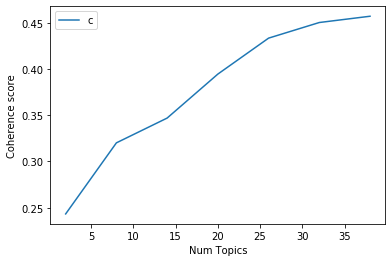

<Figure size 432x288 with 0 Axes>

In [16]:
#Model list and plot Coherence score against a number of topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
plt.savefig('Coherence score against a number of topics- Recipe_Title.png', bbox_inches='tight',dpi = 200)